In [1]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
import numpy as np
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

#Dataset analysis: describe the treebank and report any useful information, as for instance sentence length distribution.

In [3]:
dataset = load_dataset('universal_dependencies', 'en_lines', split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


Treebank Information:
----------------------
Total number of sentences: 3176
Total number of tokens: 57372
Average tokens per sentence: 18.064231738035264
Min tokens per sentence: 1
Max tokens per sentence: 98
------------------------------
Dataset keys: dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])


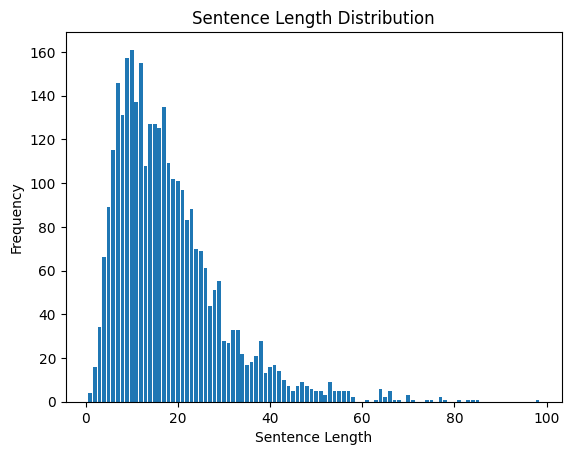

In [4]:
def print_dataset_statistics():
  # Load the dataset
  dataset = load_dataset('universal_dependencies', 'en_lines', split='train')
  tokens = dataset['tokens']

  # Calculate sentence lengths
  sentence_lengths = [len(sentence) for sentence in tokens]

  # Report the useful information
  num_sentences = len(tokens)
  total_tokens = sum(sentence_lengths)
  average_tokens = total_tokens / num_sentences
  min_tokens = min(sentence_lengths)
  max_tokens = max(sentence_lengths)

  # Sentence Length Distribution
  length_count = {}
  for length in sentence_lengths:
      length_count[length] = length_count.get(length, 0) + 1

  # Report the summary statistics
  print("Treebank Information:")
  print("----------------------")
  print("Total number of sentences:", num_sentences)
  print("Total number of tokens:", total_tokens)
  print("Average tokens per sentence:", average_tokens)
  print("Min tokens per sentence:", min_tokens)
  print("Max tokens per sentence:", max_tokens)
  print("------------------------------")
  print("Dataset keys:", dataset[0].keys())

  # Plotting the distribution
  lengths = sorted(length_count.keys())
  frequency = [length_count[length] for length in lengths]

  plt.bar(lengths, frequency)
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title("Sentence Length Distribution")
  plt.show()

print_dataset_statistics()

####SUMMARY

* Total number of sentences: 3176
* Total number of tokens: 57372
* Average tokens per sentence: 18.06
* Minimum tokens per sentence: 1
* Maximum tokens per sentence: 98
------------------------------------------------------------------------------
The dataset contains several features, including:
* 'idx': Index or ID of the sentence.
* 'text': The original text of the sentence.
* 'tokens': List of tokens in the sentence.
* 'lemmas': Lemmas (base forms) of the tokens.
* 'upos': Universal Part-of-Speech tags for the tokens.
* 'xpos': Language-specific Part-of-Speech tags for the tokens.
* 'feats': Morphological features of the tokens.
* 'head': The head (parent) of each token in the dependency tree.
* 'deprel': Dependency relation labels between tokens.
* 'deps': Additional dependency edges.
* 'misc': Miscellaneous information.

#Arc-Eager

In [5]:
class ArcEager():
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift moves to initialize the stack
    if len(self.sentence) > 1:
      self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    o2 = self.buffer[0]
    o1 = self.stack.pop()
    self.arcs[o1] = o2

  def right_arc(self):
    o1 = self.buffer[0]
    o2 = self.stack.pop()
    self.arcs[o1] = o2

    self.stack.append(o2)
    self.shift()

  def reduce(self):
    self.stack.pop()

  def is_tree_final(self):
    if len(self.buffer) == 0:

      return True

    else:

      return False


  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

In [6]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [7]:
parser.shift() # You can change the action
parser.print_configuration()

['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [8]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if(len(self.parser.buffer) != 0) and self.parser.stack[-1] != 0: # need to check buffer before performing left arc
      o1 = self.parser.stack[-1]
      o2 = self.parser.buffer[0]

      if(self.gold[o1] == o2):
        return True

    return False

  def is_right_arc_gold(self):
    if(len(self.parser.buffer) != 0):
      o1 = self.parser.buffer[0]
      o2 = self.parser.stack[len(self.parser.stack)-1]
      if self.gold[o1] == o2:
        return True

    return False

  def is_reduce(self):
    if len(self.parser.buffer) == 0:
      return True

    # Here we will perform ∃k[k<i ∧ ∃l[(k,l,j)∈A gold ∨(j,l,k)∈A gold]]
    if self.parser.stack[-1] != 0: #check if the first element is root or not
      for k in range(self.parser.stack[-1]): # look for the ones that are smaller that last stack element

        b1 = self.parser.buffer[0] #first element of the buffer. it won't raise error bcs we checked that buffer is not empty
        if((self.gold[b1] == k or self.gold[k] == b1) and self.parser.arcs[self.parser.stack[-1]] != -1):
          # Here we chech 2 condisiton
          # 1: if the first element of the buffer has head in the range
          # 2: if the ranged elements has dependent equal to first element of the buffer
          return True

    return False

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce()):
      return False

    return True

In [9]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map


In [10]:
def clean_None(example):
    indices_to_keep = [k for k, j in enumerate(example['head']) if j != 'None']
    example['head'] = [j for k, j in enumerate(example['head']) if k in indices_to_keep]
    example['tokens'] = [j for k, j in enumerate(example['tokens']) if k in indices_to_keep]
    return example

In [11]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

train_dataset = train_dataset.map(clean_None)
dev_dataset = dev_dataset.map(clean_None)
test_dataset = test_dataset.map(clean_None)

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


In [12]:
def safety_check(n):
  count=0
  for i in range(n):
    sentence, gold = train_dataset[i]["tokens"],[int(i) for i in train_dataset[i]["head"]]
    sentence = ["<ROOT>"]+ sentence
    gold = [-1] + gold

    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      if oracle.is_left_arc_gold():
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
      elif oracle.is_reduce():
        parser.reduce()
      elif oracle.is_shift_gold():
        parser.shift()


    if(parser.arcs != gold):
      count+=1
      print(sentence)
      print(parser.arcs)
      print(gold)
  return "success" if count == 0 else "error"

# look the first 500 example and check the accuracy of oracle and arc_eager
safety_check(1000)

'success'

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree. We then pair configurations and canonical actions. Since our neural classifier will look only into σ1 and β1, we do not have to record the full parser configuration.


In [13]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      # save configuration
      if len(parser.stack) <= 1:
        configuration = [-1, parser.stack[len(parser.stack)-1]]
      else:
        configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  sentence = ['[CLS]'] + sample["tokens"]

  return enc_sentence, gold_path, gold_moves, gold, sentence

In [14]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  full_sent = [s[4] for s in data]

  return sentences, paths, moves, trees, full_sent

In [15]:
BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

#Description of baseline model and BERT-based model.

#biLSTM

In [16]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:

        if len(parser.stack) <= 1:
          conf = [-1, parser.stack[len(parser.stack)-1]]
        else:
          conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]

        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

# In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly


  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
#-------------------------------------------------------------------------------- Check left arc
        if moves_argm[i] == 0: # if algorithm detects left arc
          if parsers[i].stack[-1] != 0 and len(parsers[i].buffer)>0 and parsers[i].arcs[parsers[i].stack[-1]] == -1:
            # here we checked 3 condition
            # 1) if the last element of stack is root or not
            # 2) if the buffer empty or not
            # 3) if the node that wanted to be left arc already have a head or not
            parsers[i].left_arc()

          else: # if it is not left arc...
            if len(parsers[i].buffer) > 0: # look if buffer empty. if not do a shift
              parsers[i].shift()
            else: # if buffer empty and last element of stack is root then we actualy do not need to emplement below !!!!!!!!! fix it
              parsers[i].reduce() #???? we may not need it but since it already won't enter here no problem at all

#-------------------------------------------------------------------------------- Check right arc
        elif moves_argm[i] == 1: # look at if algorithm detects right arc
          if len(parsers[i].buffer)==0:
            # here we need to check last element of buffer since we will need to reach it
            # since if buffer is empty we cannot do shift or left arc we do reduce
            parsers[i].reduce() # if buffer empty we cannot do right arc and shift we should do reduce
          else:
            parsers[i].right_arc() # if not do right arc
#-------------------------------------------------------------------------------- Check reduce
        elif moves_argm[i] == 2: # look at if algorithm detects reduce or not
          if parsers[i].arcs[parsers[i].stack[-1]] != -1 or len(parsers[i].buffer) == 0:
            # here we checked if the token that wanted to be reduced has already a head or not
            # also we checked if the buffer empty or not (in order to prevent possible infinite loop)
            parsers[i].reduce()
          else:
            # here we don't need to check the length of the buffer because we already checked above
            parsers[i].shift()
#-------------------------------------------------------------------------------- Check shift
        elif moves_argm[i] == 3: #look at if algorithm detects shift or not
          if len(parsers[i].buffer) > 0:
            # here we checked if the buffer empty or not for a shift
            parsers[i].shift()
          else:
            # here if buffer is empty we cannot do left arc, right arc or shift. we can only reduce if tree not finished
            parsers[i].reduce()

##Data set-up and training.

In [17]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [18]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees, full_sent = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels) #+ 0.0001 * sum([torch.sum(abs(param)) for param in model.parameters()])

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees, full_sent = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  print("evaluate takes time.....")

  return evaluate(gold, preds)

In [19]:
class CustomLoss(torch.nn.Module): #multimargin hinge loss
    def _init_(self):
        super(CustomLoss, self)._init_()
        self.batchsize = 32

    def forward(self, predictions, op):
        # Calculate your custom loss here
        predictions.to(device)
        # print(condition)

        filtered = predictions.clone()
        filtered[torch.arange(len(op)).to(device),op] = -float('inf')
        # print(filtered)
        loss =  torch.ones(len(op)).to(device) - predictions[torch.arange(len(op)).to(device),op] + torch.max(filtered, dim=-1)[0].to(device) # Example: mean absolute error
        # print(predictions[torch.arange(len(op)).to(device),op])
        # print(torch.max(filtered, dim=-1)[0].to(device))
        loss = torch.maximum(loss.to(device), torch.zeros(loss.shape).to(device))

        return (1/len(op)) * torch.sum(loss)

In [20]:
EMBEDDING_SIZE = 300
LSTM_SIZE = 300
LSTM_LAYERS = 2
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001   # learning rate

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
bilstm_model = Net(device)
bilstm_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(bilstm_model, train_dataloader, criterion, optimizer)
  val_uas = test(bilstm_model, dev_dataloader)
  # aa = test(model, train_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda
evaluate takes time.....
Epoch:   0 | avg_train_loss: 0.985 | dev_uas: 0.593 |
evaluate takes time.....
Epoch:   1 | avg_train_loss: 0.889 | dev_uas: 0.648 |
evaluate takes time.....
Epoch:   2 | avg_train_loss: 0.862 | dev_uas: 0.675 |
evaluate takes time.....
Epoch:   3 | avg_train_loss: 0.844 | dev_uas: 0.704 |
evaluate takes time.....
Epoch:   4 | avg_train_loss: 0.831 | dev_uas: 0.711 |
evaluate takes time.....
Epoch:   5 | avg_train_loss: 0.820 | dev_uas: 0.709 |
evaluate takes time.....
Epoch:   6 | avg_train_loss: 0.813 | dev_uas: 0.723 |
evaluate takes time.....
Epoch:   7 | avg_train_loss: 0.806 | dev_uas: 0.726 |
evaluate takes time.....
Epoch:   8 | avg_train_loss: 0.802 | dev_uas: 0.731 |
evaluate takes time.....
Epoch:   9 | avg_train_loss: 0.798 | dev_uas: 0.736 |
evaluate takes time.....
Epoch:  10 | avg_train_loss: 0.794 | dev_uas: 0.736 |
evaluate takes time.....
Epoch:  11 | avg_train_loss: 0.791 | dev_uas: 0.746 |
evaluate takes time.....
Epoch:  12 | a

In [22]:
test_uas_bilstm = test(bilstm_model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas_bilstm))

evaluate takes time.....
test_uas: 0.760


#BERT

In [23]:
class FFNN(Net):

  def __init__(self, device, bert):
    super(FFNN,self).__init__(device)

    self.w1 = torch.nn.Linear(BERT_OUT*3, MLP_SIZE, bias=True)
    self.activation = nn.LeakyReLU()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.device = device
    self.bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')

    self.freeze_bert_layers(bert, 2)

  def forward(self,x, paths):

    # print(len(x))
    h = self.context_emb(x).to(self.device)

    input = self.get_ffnn_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.ffnn_output(input).to(self.device)

    return out

  def context_emb(self,batch):
    copy = batch[:]

    batch = tokenizer(batch, truncation=True, is_split_into_words=True, padding = True, add_special_tokens = False,return_tensors='pt').to(self.device)

    emb = self.bert(**batch,  output_hidden_states=True)

    hidden_states = emb.hidden_states
    cls_emb = torch.sum(torch.stack(hidden_states[-4:]), dim=0)
    cls_emb = cls_emb.to(self.device) #(batch_size, sequence_length, emb_size)

    aligned_ids = []

    for i in copy:
      temp = token_aligner(i) #retrieve word_ids for each sentence
      aligned_ids.append(temp) #list of word_ids


    size = cls_emb.size(1) #number of token for each sentence
    # print(size, aligned_ids,len(copy))

    for j in range(cls_emb.size(0)):

      # create list of embeddings for each separate word embedding that belongs to same word
      aligned = [cls_emb[j,i].to(self.device) for i in aligned_ids[j] if i.size>0 ]
      #sum them up in order to get embedding
      aligned = [i.sum(dim = 0)/i.size(0) if i.dim() > 1 else i for i in aligned]
      # add them to the list and pad them with zeros
      conc = aligned + [torch.zeros(BERT_OUT).to(self.device) for k in range(size-len(aligned))]

      # print(cls_emb[j].size(),cls_emb.size())
      # print(conc[0].size())
      # print(torch.stack(conc).size())

      cls_emb[j] = torch.stack(conc).to(self.device)

    return cls_emb.permute(1,0,2).to(self.device)


  def freeze_bert_layers(self,bert, n_last_layers):
    num_layers = len(self.bert.encoder.layer)

    for param in self.bert.parameters():
        param.requires_grad = False

    for i in range(num_layers - n_last_layers, num_layers):
        for param in self.bert.encoder.layer[i].parameters():
            param.requires_grad = True


  def get_ffnn_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(BERT_OUT, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def ffnn_output(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, input_ids, x):

    parsers = [ArcEager(i) for i in input_ids]

    h = self.context_emb(x).to(self.device)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_ffnn_input(configurations, h)
      mlp_out = self.ffnn_output(mlp_input).to(self.device)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:

        if len(parser.stack) == 1:
          conf = [-1, parser.stack[len(parser.stack)-1]]
        else:
          conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]

        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
  #-------------------------------------------------------------------------------- Check left arc
        if moves_argm[i] == 0: # if algorithm detects left arc
          if parsers[i].stack[-1] != 0 and len(parsers[i].buffer)>0 and parsers[i].arcs[parsers[i].stack[-1]] == -1:
            # here we checked 3 condition
            # 1) if the last element of stack is root or not
            # 2) if the buffer empty or not
            # 3) if the node that wanted to be left arc already have a head or not
            parsers[i].left_arc()

          else: # if it is not left arc...
            if len(parsers[i].buffer) > 0: # look if buffer empty. if not do a shift
              parsers[i].shift()
            else: # if buffer empty and last element of stack is root then we actualy do not need to emplement below !!!!!!!!! fix it
              parsers[i].reduce() #???? we may not need it but since it already won't enter here no problem at all

  #-------------------------------------------------------------------------------- Check right arc
        elif moves_argm[i] == 1: # look at if algorithm detects right arc
          if len(parsers[i].buffer)==0:
            # here we need to check last element of buffer since we will need to reach it
            # since if buffer is empty we cannot do shift or left arc we do reduce
            parsers[i].reduce() # if buffer empty we cannot do right arc and shift we should do reduce
          else:
            parsers[i].right_arc() # if not do right arc
  #-------------------------------------------------------------------------------- Check reduce
        elif moves_argm[i] == 2: # look at if algorithm detects reduce or not
          if parsers[i].arcs[parsers[i].stack[-1]] != -1 or len(parsers[i].buffer) == 0:
            # here we checked if the token that wanted to be reduced has already a head or not
            # also we checked if the buffer empty or not (in order to prevent possible infinite loop)
            parsers[i].reduce()
          else:
            # here we don't need to check the length of the buffer because we already checked above
            parsers[i].shift()
  #-------------------------------------------------------------------------------- Check shift
        elif moves_argm[i] == 3: #look at if algorithm detects shift or not
          if len(parsers[i].buffer) > 0:
            # here we checked if the buffer empty or not for a shift
            parsers[i].shift()
          else:
            # here if buffer is empty we cannot do left arc, right arc or shift. we can only reduce if tree not finished
            parsers[i].reduce()

##Data set-up and training.

In [24]:
from transformers import AutoTokenizer, AutoModel

bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert = bert.to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
train_dataset[0]

{'idx': 'en_lines-ud-train-doc1-1',
 'text': 'Show All',
 'tokens': ['Show', 'All'],
 'lemmas': ['show', 'all'],
 'upos': [16, 11],
 'xpos': ['IMP', 'TOT-PL'],
 'feats': ["{'Mood': 'Imp', 'VerbForm': 'Fin'}", "{'Case': 'Nom'}"],
 'head': ['0', '1'],
 'deprel': ['root', 'obj'],
 'deps': ['None', 'None'],
 'misc': ['None', 'None']}

In [26]:
def token_aligner(single_sent):
    """
    This function takes an input sentence and returns a list of word indices for each token.
    It aligns the tokens to their corresponding original words in the sentence.
    """

    sent = tokenizer(single_sent, add_special_tokens=False, return_tensors='pt', is_split_into_words=True)
    # Tokenize the sentence using the tokenizer, excluding special tokens, and returning the tensors
    # The `is_split_into_words=True` ensures that the tokens are split into words

    tokens = tokenizer.tokenize(single_sent[0])
    # Extract the tokens from the input sentence
    # The [0] index is used since the input sentence is a single string inside a list

    subwords = []

    for i in range(len(sent['input_ids'][0])):
        # Iterate over the range of token indices

        where = np.where(np.array(sent.word_ids()) == i)[0]
        # Create a boolean mask that selects the indices of tokens belonging to the same original word

        subwords.append(where)
        # Append the indices of the tokens to the subwords list

    return subwords


In [27]:
single_sent = ['a', 'token', '##izer', 'b']
sent = tokenizer(single_sent, add_special_tokens = False,return_tensors='pt',is_split_into_words = True)
tokens = tokenizer.tokenize(single_sent[0])
token_aligner(single_sent),sent.word_ids()
#tokenizer.tokenize(single_sent[0])
#len(sent['input_ids'][0]), len(tokens)


([array([0]),
  array([1, 2]),
  array([3, 4, 5, 6]),
  array([7]),
  array([], dtype=int64),
  array([], dtype=int64),
  array([], dtype=int64),
  array([], dtype=int64)],
 [0, 1, 1, 2, 2, 2, 2, 3])

In [28]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch,get_gold_path = True))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

In [29]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [30]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees, full_sent = batch

    out = model(full_sent, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels) #+ 0.000001 * sum([torch.sum(abs(param)) for param in model.parameters()])

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees, full_sent = batch
    with torch.no_grad():
      pred = model.infere(sentences, full_sent)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [31]:
EMBEDDING_SIZE = 200
BERT_OUT = 768
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 23
LR = 3e-4

In [32]:
print("Device:", device)
bert_model = FFNN(device, bert)
bert_model.to(device)

criterion = CustomLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
  avg_train_loss = train(bert_model, train_dataloader, criterion, optimizer)
  val_uas = test(bert_model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | avg_train_loss: 0.392 | dev_uas: 0.759 |
Epoch:   1 | avg_train_loss: 0.226 | dev_uas: 0.783 |
Epoch:   2 | avg_train_loss: 0.184 | dev_uas: 0.816 |
Epoch:   3 | avg_train_loss: 0.165 | dev_uas: 0.834 |
Epoch:   4 | avg_train_loss: 0.151 | dev_uas: 0.850 |
Epoch:   5 | avg_train_loss: 0.141 | dev_uas: 0.847 |
Epoch:   6 | avg_train_loss: 0.136 | dev_uas: 0.848 |
Epoch:   7 | avg_train_loss: 0.129 | dev_uas: 0.859 |
Epoch:   8 | avg_train_loss: 0.122 | dev_uas: 0.853 |
Epoch:   9 | avg_train_loss: 0.117 | dev_uas: 0.854 |
Epoch:  10 | avg_train_loss: 0.116 | dev_uas: 0.858 |
Epoch:  11 | avg_train_loss: 0.110 | dev_uas: 0.864 |
Epoch:  12 | avg_train_loss: 0.105 | dev_uas: 0.866 |
Epoch:  13 | avg_train_loss: 0.101 | dev_uas: 0.864 |
Epoch:  14 | avg_train_loss: 0.102 | dev_uas: 0.869 |
Epoch:  15 | avg_train_loss: 0.095 | dev_uas: 0.869 |
Epoch:  16 | avg_train_loss: 0.095 | dev_uas: 0.862 |
Epoch:  17 | avg_train_loss: 0.092 | dev_uas: 0.869 |
Epoch:  18 | avg_train_loss:

In [33]:
test_uas_bert = test(bert_model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas_bert))

test_uas: 0.876


#Evaluation: use unlabeled attachment score (UAS). Draw a comparison between the two models and perform some error analysis for the BERT-based model.

In [34]:
def error_analysis(model, dataloader):
    model.eval()
    errors = []

    for batch in dataloader:
        sentences, paths, moves, trees, full_sent = batch
        with torch.no_grad():
            pred = model.infere(sentences, full_sent)

        for i, (p, g) in enumerate(zip(pred, trees)):
            if p != g:
                error = {
                    "sentence": full_sent[i],
                    "predicted_tree": p,
                    "gold_tree": g
                }
                errors.append(error)

    return errors

In [35]:
# Error Analysis
print('test_uas_bert: ',test_uas_bert)
print('test_uas_bilstm: ',test_uas_bilstm)
print("---------------------------")

# Catch errors
errors = error_analysis(bert_model, test_dataloader)
for error in errors:
    print("Sentence:", error["sentence"])
    print("Predicted Tree:", error["predicted_tree"])
    print("Gold Tree:", error["gold_tree"])
    print("---------------------------")

test_uas_bert:  0.8763790664780764
test_uas_bilstm:  0.7595473833097596
---------------------------
Sentence: ['[CLS]', 'When', 'you', 'move', 'a', 'field', 'to', 'the', 'series', 'area', ',', 'the', 'unique', 'items', 'of', 'data', 'within', 'the', 'field', 'are', 'displayed', 'as', 'data', 'series', 'in', 'the', 'chart', '.']
Predicted Tree: [-1, 3, 3, 20, 5, 3, 9, 9, 9, 3, 3, 13, 13, 20, 15, 13, 18, 18, 15, 20, 0, 23, 23, 20, 26, 26, 23, 20]
Gold Tree: [-1, 3, 3, 20, 5, 3, 9, 9, 9, 3, 3, 13, 13, 20, 15, 13, 18, 18, 15, 20, 0, 23, 23, 20, 26, 26, 20, 20]
---------------------------
Sentence: ['[CLS]', 'Category', 'labels', 'usually', 'appear', 'across', 'the', 'x', 'axis', 'of', 'the', 'chart', ',', 'although', 'this', 'can', 'vary', 'depending', 'on', 'the', 'type', 'of', 'chart', 'you', 'are', 'using', '.']
Predicted Tree: [-1, 2, 4, 4, 0, 8, 8, 8, 4, 11, 11, 8, 16, 16, 16, 16, 4, 16, 20, 20, 17, 22, 20, 25, 25, 22, 4]
Gold Tree: [-1, 2, 4, 4, 0, 8, 8, 8, 4, 11, 11, 8, 16, 16, 16, 